Data Mining dan Data Warehouse (D)</br>
**ABIMANYU DAMARJATI**</br>
**2110511110**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
import tracemalloc
import time

In [2]:
data = pd.read_csv('./data/rekap-data-bulanan-covid-19-bulan-november-tahun-2021.csv')

data.head()

,tanggal,id_kel,nama_provinsi,nama_kota,nama_kecamatan,nama_kelurahan,kategori,sub_kategori,jumlah
0,2021-11-06,3172051003,DKI JAKARTA,JAKARTA UTARA,PADEMANGAN,ANCOL,SUSPEK,Perawatan RS,0
1,2021-11-06,3173041007,DKI JAKARTA,JAKARTA BARAT,TAMBORA,ANGKE,SUSPEK,Perawatan RS,0
2,2021-11-06,3175041005,DKI JAKARTA,JAKARTA TIMUR,KRAMAT JATI,BALE KAMBANG,SUSPEK,Perawatan RS,0
3,2021-11-06,3175031003,DKI JAKARTA,JAKARTA TIMUR,JATINEGARA,BALI MESTER,SUSPEK,Perawatan RS,0
4,2021-11-06,3175101006,DKI JAKARTA,JAKARTA TIMUR,CIPAYUNG,BAMBU APUS,SUSPEK,Perawatan RS,0


In [3]:
class Column:
    tanggal = 'tanggal'
    id_kelurahan = 'id_kel'
    nama_provinsi = 'nama_provinsi'
    nama_kota = 'nama_kota'
    nama_kecamatan = 'nama_kecamatan'
    nama_kelurahan = 'nama_kelurahan'
    kategori = 'kategori'
    sub_kategori = 'sub_kategori'
    jumlah = 'jumlah'

Memilih kolom yang akan digunakan

In [4]:
data = data[[
    Column.tanggal,
    Column.nama_kelurahan,
    Column.kategori,
    Column.jumlah,
]]

data

,tanggal,nama_kelurahan,kategori,jumlah
0,2021-11-06,ANCOL,SUSPEK,0
1,2021-11-06,ANGKE,SUSPEK,0
2,2021-11-06,BALE KAMBANG,SUSPEK,0
3,2021-11-06,BALI MESTER,SUSPEK,0
4,2021-11-06,BAMBU APUS,SUSPEK,0
...,...,...,...,...
22423,2021-11-27,UTAN KAYU SELATAN,POSITIF,0
22424,2021-11-27,UTAN KAYU UTARA,POSITIF,1
22425,2021-11-27,UTAN PANJANG,POSITIF,0
22426,2021-11-27,WARAKAS,POSITIF,0


Menghapus jika ada data yang kosong

In [5]:
data = data.dropna(axis=0, how="any")

Mengubah format tanggal menjadi format datetime

In [6]:
data[Column.tanggal] = pd.to_datetime(data.tanggal, infer_datetime_format=True).dt.date

data

,tanggal,nama_kelurahan,kategori,jumlah
0,2021-11-06,ANCOL,SUSPEK,0
1,2021-11-06,ANGKE,SUSPEK,0
2,2021-11-06,BALE KAMBANG,SUSPEK,0
3,2021-11-06,BALI MESTER,SUSPEK,0
4,2021-11-06,BAMBU APUS,SUSPEK,0
...,...,...,...,...
22423,2021-11-27,UTAN KAYU SELATAN,POSITIF,0
22424,2021-11-27,UTAN KAYU UTARA,POSITIF,1
22425,2021-11-27,UTAN PANJANG,POSITIF,0
22426,2021-11-27,WARAKAS,POSITIF,0


#### Visualisasi

Jumlah kasus dan kematian dalam kurun waktu per minggu, setiap data dibagi jika jumlah kasus melebihi 100

In [7]:
dfl = data[[
        Column.tanggal, 
        Column.kategori, 
        Column.jumlah
    ]].where(
        data[Column.kategori] == "POSITIF"
    ).groupby([Column.tanggal]).sum().reset_index()

dfl = dfl[(dfl[Column.jumlah] >= 10)].melt(id_vars=Column.tanggal, value_vars=[Column.jumlah])

dfl

,tanggal,variable,value
0,2021-11-06,jumlah,720956.0
1,2021-11-13,jumlah,721299.0
2,2021-11-20,jumlah,721630.0
3,2021-11-27,jumlah,721878.0


In [8]:
vis_lp = px.line(dfl, x=Column.tanggal, y='value', color='variable')
vis_lp.update_layout(
                     title='COVID-19 in DKI Jakarta: total number of cases for each kelurahan on November 2021',
                     xaxis_title='DKI Jakarta', yaxis_title='Number of cases', 
                     legend=dict(x=0.02, y=0.98))
vis_lp.show()

Visualisasi bar plot jumlah kasus positif per kelurahan

In [9]:
dfl = data[[
        Column.nama_kelurahan, 
        Column.kategori, 
        Column.jumlah
    ]].where(
        data[Column.kategori] == "POSITIF"
    ).groupby([Column.nama_kelurahan]).sum().sort_values(Column.jumlah, ascending=False).reset_index()

dfl = dfl[(dfl[Column.jumlah] >= 10)].melt(id_vars=Column.nama_kelurahan, value_vars=[Column.jumlah])

dfl

,nama_kelurahan,variable,value
0,JAGAKARSA,jumlah,26456.0
1,KAPUK,jumlah,26127.0
2,SUNTER JAYA,jumlah,24300.0
3,PEJAGALAN,jumlah,24124.0
4,CENGKARENG TIMUR,jumlah,24071.0
...,...,...,...
262,ROA MALAKA,jumlah,1109.0
263,PULAU PARI,jumlah,992.0
264,PULAU KELAPA,jumlah,680.0
265,PULAU UNTUNG JAWA,jumlah,552.0


In [10]:
vis_lp = px.bar(dfl, x=Column.nama_kelurahan, y='value', color=np.log(dfl['value']), color_continuous_scale=px.colors.sequential.Agsunset)
vis_lp.update_layout(
                     title='COVID-19 in DKI Jakarta: total number of cases for each kelurahan on November 2021',
                     xaxis_title='DKI Jakarta', yaxis_title='Number of cases', 
                     legend=dict(x=0.02, y=0.98))
vis_lp.show()

Normalization

In [11]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[Column.jumlah].values.reshape(-1, 1))

In [12]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

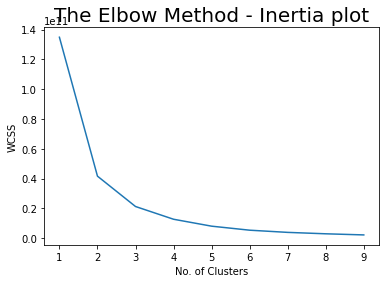

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#Elbow Method - Inertia plot
inertia = []
#looping the inertia calculation for each k
for k in range(1, 10):
    #Assign KMeans as cluster_model
    cluster_model = KMeans(n_clusters = k, random_state = 24)
    #Fit cluster_model to X
    cluster_model.fit(data[Column.jumlah].values.reshape(-1, 1))
    #Get the inertia value
    inertia_value = cluster_model.inertia_
    #Append the inertia_value to inertia list
    inertia.append(inertia_value)
##Inertia plot
plt.plot(range(1, 10), inertia)
plt.title('The Elbow Method - Inertia plot', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('WCSS')
plt.show()

In [14]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

3

> Menggunakan library kneed untuk mencari elbow dan mendapatkan hasil k = 3.

In [15]:
# starting the memory and execution time monitoring
tracemalloc.start()
st = time.time()

kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=100,
    random_state=42
)

kmeans.fit(scaled_features)
# get the end execution time
et = time.time()

# displaying the memory
print('Execution time:', et - st, 'seconds')
print('Memory:', tracemalloc.get_traced_memory())
 
# stopping the library
tracemalloc.stop()

pred = kmeans.fit_predict(scaled_features)
data['K-means'] = pred


Execution time: 0.20503616333007812 seconds
Memory: (99505, 1997365)


In [16]:
kmeans.inertia_

3543.6980179343414

In [17]:
kmeans.cluster_centers_

array([[ 1.59240022],
       [ 4.85854532],
       [-0.28374749]])

In [18]:
kmeans.n_iter_

17

In [19]:
kmeans.labels_[:5]

array([2, 2, 2, 2, 2], dtype=int32)

In [20]:
vis_tmap = px.treemap(data.reset_index(), path=['K-means', Column.nama_kelurahan], values=Column.jumlah)
vis_tmap.update_layout(title='K-means clusters')
vis_tmap.show()

/Users/abimanyu/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/abimanyu/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



# **Hierarchical Clustering**

In [21]:
from sklearn.cluster import AgglomerativeClustering

# starting the memory and execution time monitoring
tracemalloc.start()
st = time.time()

model = AgglomerativeClustering(linkage="ward", 
                                distance_threshold = 7, 
                                n_clusters=None)

model.fit(scaled_features)

# get the end execution time
et = time.time()

# displaying the memory
print('Execution time:', et - st, 'seconds')
print('Memory:', tracemalloc.get_traced_memory())
 
# stopping the library
tracemalloc.stop()

Execution time: 20.365188121795654 seconds
Memory: (1270553, 2263478856)


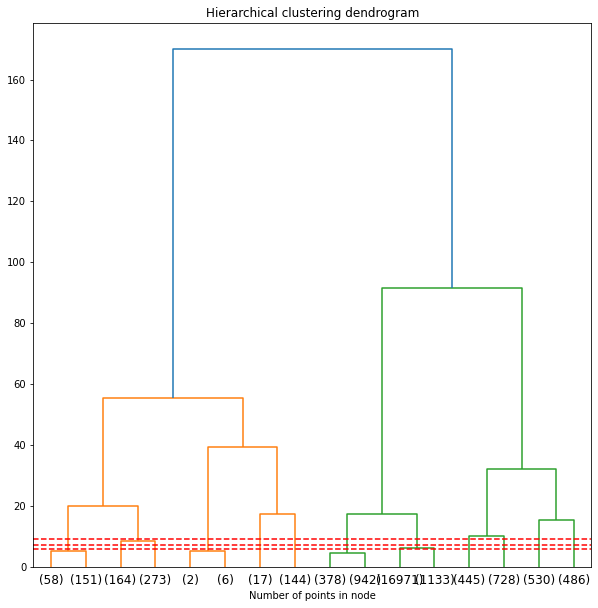

In [22]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count +=1
            else:
                current_count += counts[child_idx-n_samples]
        counts[i] = current_count
        
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                     counts]).astype(float)
    
    dendrogram(linkage_matrix, **kwargs)
fig, ax = plt.subplots(figsize = (10,10))
ax.set_title("Hierarchical clustering dendrogram")
#plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.axhline(y = 7, color = "r", linestyle = "--")
plt.axhline(y = 6, color = "r", linestyle = "--")
plt.axhline(y = 9, color = "r", linestyle = "--")
ax.set_xlabel("Number of points in node")
plt.show()

# **Evaluation**

In [23]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_moons
from sklearn.metrics import silhouette_score, adjusted_rand_score

In [24]:
# Instantiate k-means and dbscan algorithms
kmeans = KMeans(n_clusters=3)
hierarchical = AgglomerativeClustering(linkage="ward", n_clusters=3)

# Fit the algorithms to the features
kmeans.fit(scaled_features)
hierarchical.fit(scaled_features)

AgglomerativeClustering(n_clusters=3)

In [25]:
# Compute the silhouette scores for each algorithm
kmeans_silhouette = silhouette_score(
    scaled_features, kmeans.labels_
).round(2)
hierarchical_silhouette = silhouette_score(
   scaled_features, hierarchical.labels_
).round (2)

In [26]:
print(kmeans_silhouette)
print(hierarchical_silhouette)

0.89
0.88
